*** Demo of the variational Holder Bound on a 2D Gaussian truncated in the positive orthant ***

In [1]:

import numpy as np
from utils import logodds, sigmoid, empty, flatten, reshape
from matplotlib import pyplot as plt
from scipy.integrate import quad, dblquad
from scipy.optimize import fmin, fmin_bfgs
from numpy.linalg import det # for Gaussian integrals



In [ ]:
def factor_scaled_integral_gauss(params, theta, inv_alpha, delta):
    d = params.A.shape[0]
    alpha = 1. / inv_alpha
    theta_scaled = delta * theta
    #I = inv_alpha * gauss_integral(np.dot(params.A, alpha) + np.diag(theta_scaled[:d]) * alpha,\
    I = inv_alpha * gauss_integral(params.A * alpha + np.diag(theta_scaled[:d]) * alpha,\
    			params.b * alpha + theta_scaled[d:] * alpha)
    I_grad = 0
    return (I, I_grad)


def gauss_integral(A, b):
    detA = det(A);
    if detA < 1e-12:
        J = np.inf;
#        Jgrad = np.inf;
    else:
        d = A.shape[0]
        J = d / 2 *np.log(2*np.pi) - 0.5*np.log(detA) + 0.5*np.sum(b*np.linalg.solve(A, b))
#        Jgrad = 0
    return J


def factor_scaled_integral_univ(log_func,theta,inv_alpha,delta,L=None):
    """
    factor_scaled_integral_univ

    L are lipschitz constants for the factors derivatives
    """
    theta = reshape(theta,(theta.size/2,2))
    d = theta.shape[0]
    theta_mod = delta * theta / inv_alpha
    if L is None:
        L = np.ones(len(log_func)) * 0.01 # to avoid integrating the step function over reals
    ints = np.zeros(d)
    for i in range(d):
        if L[i]/inv_alpha < theta_mod[i,0]:  # numerical check that the integral is finite      
            wp = 1/np.sqrt(np.abs(theta_mod[i,0]));        
#            ints[i] = log(integral(lambda t: np.exp(log_func[i](t)/inv_alpha - 0.5*theta_mod[i,0]*np.power(t, 2) + theta_mod[i,1]*t),-inf,inf,'Waypoints',[-wp 0 wp]));
            ints[i] = np.log(quad(lambda t: np.exp(log_func[i](t)/inv_alpha - 0.5*theta_mod[i,0]*np.power(t, 2) + theta_mod[i,1]*t),-np.inf,np.inf)[0])#,'Waypoints',[-wp 0 wp]));
        else:   
            ints[i] = np.inf
            break
    I = inv_alpha * np.sum(ints)
    I_grad = 0
    return (I, I_grad)


def upper_bound_logpartition(fg,theta,inv_alpha,delta=1):
    logIfg = np.zeros(2)
    [logIfg[0], logIf_grad] = factor_scaled_integral_univ(fg[0],theta,inv_alpha,delta)
    [logIfg[1], logIg_grad] = factor_scaled_integral_gauss(fg[1],theta,1-inv_alpha,-delta)
    logIfg = np.real(logIfg)
    logIbar = np.sum(logIfg)
    logIbar_grad = logIf_grad + logIg_grad
    return (logIbar, logIbar_grad, logIfg)


In [2]:
d = 2 # dimension of the truncated Gaussian distribution to be integrated

In [4]:
params = empty()
params.A = np.array([[0.5, 0.57], [0.57, 1]])
params.b = np.array([1.6, 2.1])
lower_lims = np.array([-1,-1])
upper_lims = np.array([8, 6])

In [6]:
    
log_step_func = lambda t: -1e10 * (t<0)

#first function: step function in each of the directions
log_f_vec = lambda t: log_step_func(t[:,0]) + log_step_func(t[:,1]) 
log_f = lambda t: log_step_func(t[0]) + log_step_func(t[1]) 

# second function: Correlated Gaussian
log_g_vec = lambda t: -0.5 * np.sum(t * np.dot(t, params.A), 1) + np.sum(t * params.b, 1) 
log_g = lambda t: -0.5 * np.sum(t * np.dot(t, params.A)) + np.sum(t * params.b) 

# pivot function: diagonal covariance Gaussian
log_r_vec = lambda t, theta: np.sum(-0.5*np.power(t,2)*theta[:d] + t*theta[d:], 1)
log_r = lambda t, theta: -0.5*np.sum(np.power(t,2) * theta[:d]) + np.sum(t*theta[d:])

fg = ((log_step_func, log_step_func), params)   # FIXME: tuple or list?



In [8]:
INF = np.inf

# optimal integral
Istar = np.log(dblquad(lambda y, x: np.exp(log_f(np.array([x, y])) + log_g(np.array([x, y]))),-INF,INF,lambda x:-INF,lambda x: INF)[0])
# exact first moment in each of the dimension
mxstar = np.exp(-Istar)*dblquad(lambda y, x: x*np.exp(log_f(np.array([x, y]))+log_g(np.array([x, y]))),-INF,INF,lambda x: -INF,lambda x: INF)[0]
mystar = np.exp(-Istar)*dblquad(lambda y, x: y*np.exp(log_f(np.array([x, y]))+log_g(np.array([x, y]))),-INF,INF,lambda x:-INF,lambda x: INF)[0]
print 'Istar %.3f, mxstar = %.3f, mystar = %.3f' % (Istar, mxstar, mystar)



Istar 4.710, mxstar = 2.122, mystar = 1.299


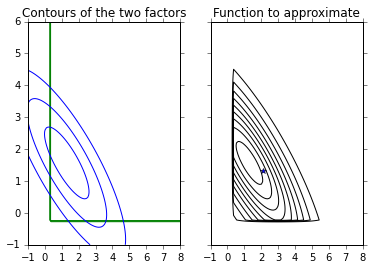

In [9]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

ng = 100 # grid size
gx, gy = np.meshgrid(np.linspace(lower_lims[0], upper_lims[0], ng), np.linspace(lower_lims[1], upper_lims[1], ng))
gridpoints = np.c_[flatten(gx), flatten(gy)]
valf = np.exp(log_f_vec(gridpoints)) #first function
valg = np.exp(log_g_vec(gridpoints)) #second function

plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
cs11 = ax1.contour(gx, gy, valf.reshape(ng,ng), 3, colors='g') 
cs12 = ax1.contour(gx, gy, valg.reshape(ng,ng), 3, colors='b') 
ax1.set_title('Contours of the two factors')

cs2 = ax2.contour(gx, gy, (valf * valg).reshape(ng,ng), 10, colors='k') 
ax2.set_title('Function to approximate')

ax2.plot(mxstar, mystar,marker='*')


In [10]:

## checks that the VH bound is an upper bound
rho0 = .5 # rho = 1/alpha_1 = 1 - 1/alpha_2
theta0 = np.r_[np.diag(A)*0.1, b/2.] # the initial parameter
UB0 = upper_bound_logpartition(fg,theta0,rho0)[0]
print 'The exact integral is %4.3f' % Istar
print 'The variational holder bound gives %4.3f for the initial pivot function with parameters %s' % (UB0, theta0)

res0 = np.r_[theta0, logodds(rho0)]
objfun = lambda t: upper_bound_logpartition(fg,t[:-1],sigmoid(t[-1]))[0]

res1 = fmin(objfun, res0, xtol=1e-7)
#    res1 = fmin_bfgs(objfun, res0)     # FIXME: seems to be numerically unstable

theta1 = res1[:-1]
rho1 = sigmoid(res1[-1])
UB1, tmp, IfIg = upper_bound_logpartition(fg,theta1,rho1)
print 'optimized upper bound = %f' % UB1


(4,)
The exact integral is 4.710
The variational holder bound gives 15.728 for the initial pivot function with parameters [ 0.05  0.1   0.8   1.05]
Optimization terminated successfully.
         Current function value: 5.087771
         Iterations: 402
         Function evaluations: 668
optimized upper bound = 5.087771


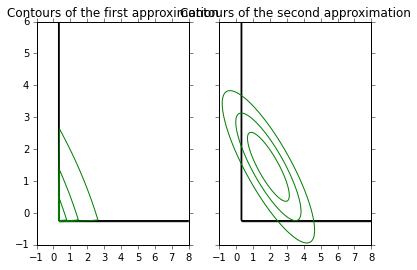

In [14]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

ng = 100 # grid size
gx, gy = np.meshgrid(np.linspace(lower_lims[0], upper_lims[0], ng), np.linspace(lower_lims[1], upper_lims[1], ng))
gridpoints = np.c_[flatten(gx), flatten(gy)]
val_approx1 = np.exp(1./rho1 * log_f_vec(gridpoints) + 1./rho1*log_r_vec(gridpoints,theta1)) #first approximation
val_approx2 = np.exp(1./(1-rho1) * log_g_vec(gridpoints) - 1./(1-rho1)*log_r_vec(gridpoints,theta1)) #first approximation


plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
cs11 = ax1.contour(gx, gy, valf.reshape(ng,ng), 3, colors='k') 
cs12 = ax1.contour(gx, gy, val_approx1.reshape(ng,ng), 3, colors='g') 
ax1.set_title('Contours of the first approximation')

cs21 = ax2.contour(gx, gy, valf.reshape(ng,ng), 3, colors='k') 
cs22 = ax2.contour(gx, gy, val_approx2.reshape(ng,ng), 3, colors='g') 
ax2.set_title('Contours of the second approximation')

#cs2 = ax2.contour(gx, gy, (valf * valg).reshape(ng,ng), 10, colors='k') 
#ax2.set_title('Function to approximate')

#ax2.plot(mxstar, mystar,marker='*')





In [11]:
# Sanity check: compute the two integrals numerically to see if we recover the optimized bound

# NOTE: I_fr and I_gr are raw values (before applying logarithm, unlike Istar)
I_fr = dblquad(lambda y, x: np.exp(1./rho1*log_f(np.array([x, y])) + 1./rho1*log_r(np.array([x, y]),theta1)),-INF,INF,lambda x: -INF, lambda x: INF)[0]
mx_fr = 1/I_fr*dblquad(lambda y, x: x*np.exp(1./rho1*log_f(np.array([x, y])) + 1./rho1*log_r(np.array([x, y]),theta1)),-INF,INF,lambda x:-INF,lambda x: INF)[0]
my_fr = 1/I_fr*dblquad(lambda y, x: y*np.exp(1./rho1*log_f(np.array([x, y])) + 1./rho1*log_r(np.array([x, y]),theta1)),-INF,INF,lambda x:-INF,lambda x: INF)[0]
print 'I_fr %.3f, mx_fr = %.3f, my_fr = %.3f' % (I_fr, mx_fr, my_fr)

I_gr = dblquad(lambda y, x: np.exp(1./(1-rho1)*log_g(np.array([x, y])) - 1./(1-rho1)*log_r(np.array([x, y]),theta1)),-INF,INF,lambda x: -INF, lambda x: INF)[0]
mx_gr = 1/I_gr*dblquad(lambda y, x: x*np.exp(1./(1-rho1)*log_g(np.array([x, y])) - 1./(1-rho1)*log_r(np.array([x, y]),theta1)),-INF,INF,lambda x:-INF,lambda x: INF)[0]
my_gr = 1/I_gr*dblquad(lambda y, x: y*np.exp(1./(1-rho1)*log_g(np.array([x, y])) - 1./(1-rho1)*log_r(np.array([x, y]),theta1)),-INF,INF,lambda x:-INF,lambda x: INF)[0]
print 'I_gr %.3f, mx_gr = %.3f, my_gr = %.3f' % (I_gr, mx_gr, my_gr)

UB2 = np.log(I_fr)*rho1 + np.log(I_gr)*(1.-rho1)
print 'alpha_1 = %.3f, log(I_fr)/alpha_1 = %.3f, alpha_2 = %.3f, log(I_gr)/alpha_2 = %.3f, UB2 = %.3f' % \
        (1./rho1, np.log(I_fr)*rho1, 1./(1-rho1), np.log(I_gr)*(1.-rho1), UB2)



I_fr 3.405, mx_fr = 2.144, my_fr = 1.264
I_gr 8191.113, mx_gr = 2.144, my_gr = 1.264
alpha_1 = 1.985, log(I_fr)/alpha_1 = 0.617, alpha_2 = 2.016, log(I_gr)/alpha_2 = 4.470, UB2 = 5.088
